# Lab:  Model Order Selection for Neural Data

Machine learning is a key tool for neuroscientists to understand how sensory and motor signals are encoded in the brain.  In addition to improving our scientific understanding of neural phenomena, understanding neural encoding is critical for brain machine interfaces.  In this lab, you will use model selection for performing some simple analysis on real neural signals.  

Before doing this lab, you should review the ideas in the [polynomial model selection demo](./polyfit.ipynb).  In addition to the concepts in that demo, you will learn to:
* Represent neural time-series data in arrays
* Load data from a pickle file
* Describe and fit memoryless linear models
* Describe and fit linear time-series models with delays
* Fit linear models with multiple target outputs
* Select the optimal delay via cross-validation

## Loading the data

The data in this lab comes from neural recordings described in:

<a href="http://jn.physiology.org/content/106/2/764.short">
Stevenson, Ian H., et al. "Statistical assessment of the stability of neural movement representations." Journal of neurophysiology 106.2 (2011): 764-774</a>

Neurons are the basic information processing units in the brain.  Neurons communicate with one another via *spikes* or *action potentials* which are brief events where voltage in the neuron rapidly rises then falls.  These spikes trigger the electro-chemical signals between one neuron and another.  In this experiment, the spikes were recorded from 196 neurons in the primary motor cortex (M1) of a monkey using an electrode array implanted onto the surface of a monkey's brain.  During the recording, the monkey performed several reaching tasks and the position and velocity of the hand was recorded as well.  

The goal of the experiment is to try to *read the monkey's brain*:  That is, predict the hand motion from the neural signals from the motor cortex.

We first load the key packages.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

The full data is available on the CRCNS website  http://crcns.org/data-sets/movements/dream.  This website has a large number of great datasets and can be used for projects as well.  However, the raw data files can be quite large.  To make the lab easier, the [Kording lab](http://kordinglab.com/) at UPenn has put together an excellent [repository](https://github.com/KordingLab/Neural_Decoding) where they have created simple pre-processed versions of the data.  You can download the file `example_data_s1.pickle` from the [Dropbox link](https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=0).  Alternatively, you can directly run the following code.  This may take a little while to download since the file is 26 MB.

In [2]:
fn_src = 'https://www.dropbox.com/sh/n4924ipcfjqc0t6/AADOv9JYMUBK1tlg9P71gSSra/example_data_s1.pickle?dl=1'
fn_dst = 'example_data_s1.pickle'

import os
from six.moves import urllib

if os.path.isfile(fn_dst):
    print('File %s is already downloaded' % fn_dst)
else:        
    urllib.request.urlretrieve(fn_src, fn_dst)

File example_data_s1.pickle is already downloaded


The file is a *pickle* data structure, which is a package to serialize python objects into data files.  Once you have downloaded the file, you can run the following command to retrieve the data from the pickle file.

In [3]:
with open('example_data_s1.pickle', 'rb') as fp:
    X,y = pickle.load(fp)

The matrix `X` is matrix of spike counts where `X[i,j]` is the number of spikes from neuron `j` in time bin `i`.
The matrix `y` has two columns:
* `y[i,0] = ` velocity of the monkey's hand in the x-direction
* `y[i,1] = ` velocity of the monkey's hand in the y-direction
Our goal will be to predict `y` from `X`.  

Each time bin represent `tsamp=0.05` seconds of time.  Using `X.shape` and `y.shape` compute and print:
* `nt = ` the total number of time bins
* `nneuron = ` the total number of neurons
* `nout = ` the total number of output variables to track = number of columns in `y`
* `ttotal = ` total time of the experiment is seconds. 

In [4]:
X

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 1., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [5]:
fp

<_io.BufferedReader name='example_data_s1.pickle'>

In [6]:
pickle

<module 'pickle' from 'C:\\User_MJJ_things\\Anaconda_software\\lib\\pickle.py'>

In [7]:
y

array([[ 1.51037413e-01,  1.50912405e-01],
       [-1.39498351e-01,  1.10064258e-01],
       [-3.55773944e-01, -3.96432704e-01],
       ...,
       [ 3.19722904e-06, -1.32722761e-06],
       [ 7.24814520e-07,  3.01404519e-06],
       [ 9.51148351e-07, -1.48976504e-06]])

In [8]:
tsamp = 0.05  # sampling time in seconds

nt = X.shape[0]
nneuron = X.shape[1]
nout = y.shape[1]
ttotal = tsamp * nt

## Fitting a Memoryless Linear Model

Let's first try a simple linear regression model to fit the data.

First, use the `train_test_split` function to split the data into training and test.  Let `Xtr,ytr` be the training data set and `Xts,yts` be the test data set.  Use `test_size=0.33` so `1/3` of the data is used for test.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.33)

Now, fit a linear model using `Xtr,ytr`.  Make a prediction  `yhat` using `Xts`.  Compare `yhat` to `yts` to measure `rsq`, the  `R^2`.  You can use the `r2_score` method. Print the `rsq` value.  You should get `rsq` of around `0.45`. 

In [10]:
yhat = LinearRegression().fit(Xtr,ytr).predict(Xts)
rsq = r2_score(yts, yhat)
rsq

0.46302100514141964

In [11]:
yhat

array([[-11.11515131,  -5.12821367],
       [ -0.74096402,  -5.6475315 ],
       [ -3.55550258,  -2.88021884],
       ...,
       [ -6.96536526,  -1.61593734],
       [  0.17090286,   4.1537287 ],
       [  2.05554204,   3.2730395 ]])

It is useful to plot the predicted vs. true values.  Since we have two outputs, create two `subplots` using the `plt.subplot()` command.  In plot `i=0,1`, plot `yhat[:,i]` vs. `yts[:,i]` with a scatter plot.   Label the axes of the plots.  You may also use the command:

    plt.figure(figsize=(10,5))
    
to make the figures a little larger.

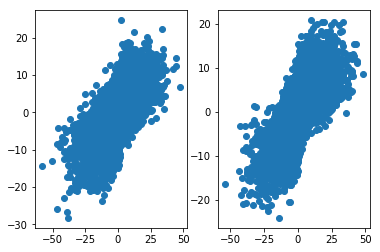

In [12]:
xtsa = np.arange(0, Xts.shape[0] / 2, 1 / 2)
plt.plot(figsize = (10, 5))
plt.subplot(1,2,1)
plt.scatter(yts[:,0], yhat[:,0],marker = "o")
#plt.scatter(xtsa, yts[:,0],marker = "^")
plt.subplot(1,2,2)
plt.scatter(yts[:,1], yhat[:,1])
#plt.scatter(xtsa, yts[:,1])

In [13]:
#np.set_printoptions(threshold=np.inf)
(yhat == yts)

array([[False, False],
       [False, False],
       [False, False],
       ...,
       [False, False],
       [False, False],
       [False, False]])

In [14]:
import numpy as np
a = np.array([1, 2, 3])
b = np.array([4, 5, 6])
b1 = np.array([7, 8, 9])
c = np.vstack((a,b))
print(c.shape)
d = np.hstack((a,b))
print(d.shape)
print(d)
e = np.vstack((a,b,b1))
print(e)
et = np.hstack((a.T,b.T,b1.T))
print(et)
eth = np.hstack((a,b,b1))
print(eth)
etr = np.vstack((a.T,b.T,b1.T))
print(etr)
ar = a.reshape(1,-1)
br = b.reshape(1,-1)
b1r = b1.reshape(1,-1)
ert = np.hstack((ar.T,br.T,b1r.T))
print(ert)
etrr = np.vstack((ar.T,br.T,b1r.T))
print(etrr)
mh = np.hstack((e, ert))
print(mh)
t1 = np.arange(10, 19, 1).reshape(3,3)
t2 = np.arange(20, 29, 1).reshape(3,3)
t3 = np.arange(30, 39, 1).reshape(3,3)
t4 = np.arange(40, 49, 1).reshape(3,3)
t = np.array([t1,t2,t3,t4])
print(t)
print(t.shape)
th = np.hstack(t[i] for i,v in enumerate(t))
print(th)
tv = np.vstack(t[i] for i,v in enumerate(t))
print(tv)
'''thc = np.hstack(t[i] for i in iter(4))
print(thc)'''

(2, 3)
(6,)
[1 2 3 4 5 6]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
[1 2 3 4 5 6 7 8 9]
[1 2 3 4 5 6 7 8 9]
[[1 2 3]
 [4 5 6]
 [7 8 9]]
[[1 4 7]
 [2 5 8]
 [3 6 9]]
[[1]
 [2]
 [3]
 [4]
 [5]
 [6]
 [7]
 [8]
 [9]]
[[1 2 3 1 4 7]
 [4 5 6 2 5 8]
 [7 8 9 3 6 9]]
[[[10 11 12]
  [13 14 15]
  [16 17 18]]

 [[20 21 22]
  [23 24 25]
  [26 27 28]]

 [[30 31 32]
  [33 34 35]
  [36 37 38]]

 [[40 41 42]
  [43 44 45]
  [46 47 48]]]
(4, 3, 3)
[[10 11 12 20 21 22 30 31 32 40 41 42]
 [13 14 15 23 24 25 33 34 35 43 44 45]
 [16 17 18 26 27 28 36 37 38 46 47 48]]
[[10 11 12]
 [13 14 15]
 [16 17 18]
 [20 21 22]
 [23 24 25]
 [26 27 28]
 [30 31 32]
 [33 34 35]
 [36 37 38]
 [40 41 42]
 [43 44 45]
 [46 47 48]]


'thc = np.hstack(t[i] for i in iter(4))\nprint(thc)'

## Fitting Models with Delay

One way we can improve the model accuracy is to used delayed version of the features.  Specifically, the model we used above mapped the features 

    yhat[i,k] = \sum_{j=0}^{p-1} X[i,j]*w[j,k] + b[k]
    
where `p` is the number of features and `w[j,k]` is a matrix of coefficients.  In this model,  `yhat[i,:]` at time `i` was only dependent on the inputs  `X[i,:]` at time `i`.  In signal processing, this is called a *memoryless* model.  However, in many physical systems, such as those that arise in neuroscience, there is a delay between the inputs `X[i,:]` and the outputs `y[i]`.  For such cases, we can use a model of the form,

    yhat[i+d,k] = \sum_{k=0}^d  \sum_{j=0}^{p-1} \sum_{m=0}^d X[i+m,j]*W[j,m,k] + b[k]
    
where `W` is a 3-dim array of coefficients where:

    W[j,m,k] is the influence of the input X[i+m,j] onto output y[i+d,k]


In signal processing, this model is called an *FIR* filter and `W[j,:,k]` is the *impulse response* from the `j`-th input to the `k`-th output.  The point is that the output at time `i+d` depends on the inputs at times `i,i+1,...,i+d`.  Hence, it depends on the last `d+1` time steps, not just the most recent time.

To translate this into a linear regression problem, complete the following function that creates a new feature and target matrix where:

    Xdly[i,:] has the rows X[i,:], X[i++1,:], ..., X[i+dly,:]
    ydly[i,:] = y[i+dly,:]
    
Thus, `Xdly[i,:]` contains all the delayed fetaures for the target `yhat`.  Note that if `X` is `n x p` then `Xdly` will be `n-dly x (dly+1)*p`.  


In [15]:
#def get_row(X, i, dly):
#    dlyarr = np.arange(0, dly + 1, 1)
#    return np.vstack(X[i + ind] for ind,vi in enumerate(dlyarr))
def create_dly_data(X,y,dly):
    """
    Create delayed data
    """    
    dlyarr = np.arange(1, dly + 1, 1)
    jarr = np.arange(0, X.shape[0] - dly, 1)
    iarr = np.arange(0, X.shape[1], 1)
    temp = np.zeros((X.shape[0] - dly, (dly + 1) * X.shape[1]), dtype=int)
    #Xdly = np.vstack(np.vstack(X[j + i] for i,vi in enumerate(dlyarr)), for j,vj in enumerate(jarr))
    #Xdly = np.vstack(X[j + i] for i,vi in enumerate(dlyarr) for j,vj in enumerate(jarr)) original:61339 now:429331
    #Xdly = np.vstack(X[j + i] for j,vj in enumerate(jarr) for i,vi in enumerate(dlyarr)) original:61339 now:429331
    #Xdly = np.hstack(get_row(X, i, dly) for i,v in enumerate(jarr))
    for i, vi in enumerate(jarr):
        tem = X[i].reshape(1,-1)
        #print(temp.shape)
        for j, vj in enumerate(dlyarr):
            tem = np.hstack((tem, X[i + vj].reshape(1,-1)))
        #tempele = np.vstack(X[i + vid].reshape(1, -1) for ind,vid in enumerate(dlyarr))
        #print(temp.shape)
        #print(X[i].shape)
        #temp[i] = np.vstack(X[i + vid] for ind,vid in enumerate(dlyarr))
        temp[i] = tem
    ydly = y[dly:, :]
    Xdly = temp
    return Xdly, ydly


In [16]:
temp = np.hstack((X[0].reshape(1,-1), X[1].reshape(1,-1)))
print(temp.shape)
print(X[0].reshape(1, -1).shape)

(1, 104)
(1, 52)


Now fit an linear delayed model with `dly=6` additional delay lags.  That is,
* Create delayed data `Xdly,ydly=create_dly_data(X,y,dly=6)`
* Split the data into training and test as before
* Fit the model on the training data
* Measure the `R^2` score on the test data

If you did this correctly, you should get a new `R^2` score around 0.69.  This is significantly better than the memoryless models.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
print(X.shape)

Xdly, ydly=create_dly_data(X,y,dly=6)
print(Xdly.shape)
print(ydly.shape)
Xtr, Xts, ytr, yts = train_test_split(Xdly, ydly, test_size = 0.5)
yts_pred = LinearRegression().fit(Xtr, ytr).predict(Xts)
rsq = r2_score(yts, yts_pred)
print(rsq)

(61339, 52)
(61333, 364)
(61333, 2)
0.689438669704457


Plot the predicted vs. true values as before. You should visually see a better fit.

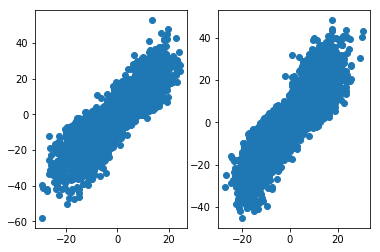

In [22]:
plt.subplot(1,2,1)
plt.scatter(yts_pred[:,0], yts[:,0])
plt.subplot(1,2,2)
plt.scatter(yts_pred[:,1], yts[:,1])

*Note*:  Fitting an FIR model with the above method is very inefficient when the number of delays, `dly` is large.  In the above method, the number of columns of `X` grows from `p` to `(dly+1)*p` and the computations become expensive with `dly` is large.  We will describe a much faster way to fit such models using gradient descent when we talk about convolutional neural networks.

## Selecting the Optimal Delay via Model Order Selection

In the previous example, we fixed `dly=6`.  We can now select the optimal delay using model order selection.  Since we have a large number of data samples, it turns out that the optimal model order uses a very high delay.  Using the above fitting method, the computations take too long.  So, to simplify the lab, we will first just pretent that we have a very limited data set.

Compute `Xred` and `yred` by taking the first `nred=6000` samples of the data `X` and `y`.  This is about 10% of the overall data.

In [24]:
nred = 6000

Xred = X[:nred]
yred = y[:nred]
print(Xred.shape)
print(yred.shape)

(6000, 52)
(6000, 2)


We will look at model orders up to `dmax=15`.  Create a delayed matrix data, `Xdly,ydly` from the reduced data, `Xred,yred` using `create_dly_data` with `dly=dmax`.

In [25]:
dmax = 15

Xdly, ydly = create_dly_data(Xred, yred, dly = dmax)
print(Xdly.shape)
print(ydly.shape)

(5985, 832)
(5985, 2)


In [26]:
from sklearn.model_selection import KFold
X1 = np.array([[1, 2], [3, 4], [1, 2], [3, 4]])
y1 = np.array([1, 2, 3, 4])
kf1 = KFold(n_splits=2)
kf1.get_n_splits(X1)
print(kf1)  
KFold(n_splits=2, random_state=None, shuffle=False)
for train_index, test_index in kf1.split(X1):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X1[train_index], X1[test_index]
    y_train, y_test = y1[train_index], y1[test_index]
    print(train_index[0])
    print(train_index[1])
    print(X_train)
    print(y_train)
    print(test_index[0])
    print(test_index[1])
    print(X_test)
    print(y_test)    

KFold(n_splits=2, random_state=None, shuffle=False)
TRAIN: [2 3] TEST: [0 1]
2
3
[[1 2]
 [3 4]]
[3 4]
0
1
[[1 2]
 [3 4]]
[1 2]
TRAIN: [0 1] TEST: [2 3]
0
1
[[1 2]
 [3 4]]
[1 2]
2
3
[[1 2]
 [3 4]]
[3 4]


Complete the following code to implement K-fold cross validation with `nfold=5` and values of delays `dtest = [0,1,...,dmax]`.

In [39]:
import  sklearn.model_selection 
import  sklearn.linear_model
import  sklearn.metrics

# Number of folds
nfold = 5
kf = sklearn.model_selection.KFold(n_splits=nfold,shuffle=True)
dtest = np.arange(0, dmax + 1, 1)
nd = len(dtest)
print(nd)
Rsqm = np.zeros((nd, nfold))

# Loop over the folds
for isplit, Ind in enumerate(kf.split(Xdly)):
    
    print("fold = %d " % isplit)
    
    # Get the training data in the split
    Itr, Its = Ind        

    for it, d in enumerate(dtest):
        se = (d - 1) * (Xdly.shape[1] // dmax)
        
        # Split the data (Xdly1,ydly) into training and test
        #Xtr, Xts = Xdly[Itr,se: ], Xdly[Its,se: ]
        #ytr, yts = y[Itr, ], y[Its, ]
        Xtr = Xdly[Itr, se:]
        ytr = ydly[Itr]
        Xts = Xdly[Its, se:]
        yts = ydly[Its]
        
        yts_p_s = sklearn.linear_model.LinearRegression().fit(Xtr, ytr).predict(Xts)
        
        Rsqm[d, isplit] = sklearn.metrics.r2_score(yts, yts_p_s)      
Rsqm

16
fold = 0 
fold = 1 
fold = 2 
fold = 3 
fold = 4 


array([[0.42839354, 0.46059745, 0.44723807, 0.45839966, 0.48809715],
       [0.63791538, 0.67160208, 0.64750368, 0.64600637, 0.67091706],
       [0.64688652, 0.67748516, 0.64917493, 0.65173303, 0.67328334],
       [0.64928652, 0.68245402, 0.65483697, 0.65633725, 0.67527009],
       [0.65310439, 0.68663549, 0.65529463, 0.65684036, 0.67761703],
       [0.65904214, 0.68766259, 0.6544322 , 0.66134889, 0.68250245],
       [0.65892699, 0.68814449, 0.65757654, 0.66344853, 0.68387766],
       [0.65634974, 0.68526469, 0.65347248, 0.66742183, 0.68104712],
       [0.655914  , 0.68256484, 0.65133329, 0.66536638, 0.68365888],
       [0.65479804, 0.67650409, 0.64832143, 0.6596149 , 0.68451906],
       [0.64838692, 0.66937199, 0.64684806, 0.65512522, 0.68125436],
       [0.63957808, 0.66038217, 0.63209689, 0.64599811, 0.67382254],
       [0.61760487, 0.63954395, 0.61361674, 0.63429681, 0.66242116],
       [0.58900256, 0.62216454, 0.58445773, 0.62357767, 0.6369343 ],
       [0.54348882, 0.5807372 , 0.

Compute the mean and standard error of the `R^2` values as a function of the model order `d`.  Use a `plt.errorbar` plot.  Label your axes.

[0.45654517 0.65478891 0.6597126  0.66363697 0.66589838 0.66899765
 0.67039484 0.66871117 0.66776748 0.6647515  0.66019731 0.65037556
 0.63349671 0.61122736 0.56868555 0.46334901]
[0.00973274 0.00691998 0.00647786 0.00642679 0.00680268 0.00671017
 0.00648424 0.00637526 0.00666277 0.0067981  0.0065992  0.00748248
 0.00872238 0.01035267 0.0092517  0.00873267]


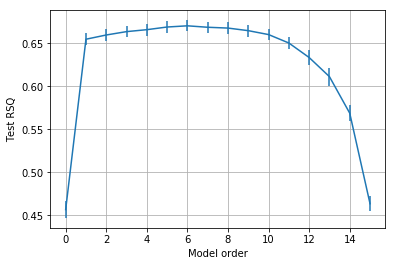

In [43]:
Rsqm_mean = np.mean(Rsqm, axis = 1)
print(Rsqm_mean)
Rsqm_std = np.std(Rsqm, axis = 1) / np.sqrt(nfold - 1)
print(Rsqm_std)
plt.errorbar(dtest, Rsqm_mean, yerr = Rsqm_std, fmt = '-')
#plt.ylim(0,1.5)
plt.xlabel('Model order')
plt.ylabel('Test RSQ')
plt.grid()

Find the optimal order `d` with the normal rule (i.e. highest test `R^2`)

The estimated model order is 6


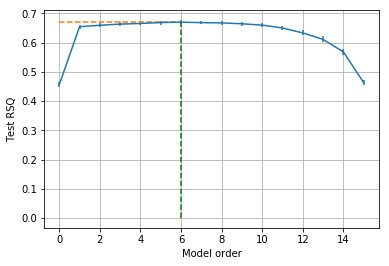

In [65]:
# Find the minimum RSS target
imax = np.argmax(Rsqm_mean)
plt.errorbar(dtest, Rsqm_mean, yerr=Rsqm_std, fmt='-')

# Plot the line at the RSQ target
plt.plot([dtest[0], dtest[imax]], [Rsqm_mean[imax], Rsqm_mean[imax]], '--')

# Plot the line at the optimal model order
plt.plot([imax,imax], [0,Rsqm_mean[imax]], 'g--')

#plt.ylim(0,1.5)
plt.xlabel('Model order')
plt.ylabel('Test RSQ')
plt.grid()

# Print results
print("The estimated model order is %d" % dopt)

Now find the optimal model order via the one SE rule (i.e. highest test `R^2` within on SE)

6
0.6639105976754488
[0.45654517 0.65478891 0.6597126  0.66363697 0.66589838 0.66899765
 0.67039484 0.66871117 0.66776748 0.6647515  0.66019731 0.65037556
 0.63349671 0.61122736 0.56868555 0.46334901]
[4 5 6 7 8 9]
The estimated model order is 4


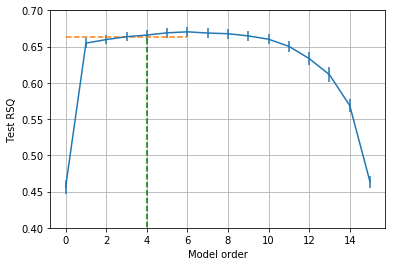

In [68]:
# Find the minimum RSS target
imax = np.argmax(Rsqm_mean)
Rsqm_tgt = Rsqm_mean[imax] - Rsqm_std[imax]
print(imax)
print(Rsqm_tgt)
print(Rsqm_mean)
# Find the lowest model order below the target
I = np.where(Rsqm_mean >= Rsqm_tgt)[0]
#print("I")
print(I)
iopt = I[0]
dopt = dtest[iopt]

plt.errorbar(dtest, Rsqm_mean, yerr=Rsqm_std, fmt='-')

# Plot the line at the RSQ target
plt.plot([dtest[0], dtest[imax]], [Rsqm_tgt, Rsqm_tgt], '--')

# Plot the line at the optimal model order
plt.plot([dopt,dopt], [0,Rsqm_mean[dopt]], 'g--')

plt.ylim(0.4, 0.7)
plt.xlabel('Model order')
plt.ylabel('Test RSQ')
plt.grid()

# Print results
print("The estimated model order is %d" % dopt)